# Implementing FRI for synthetic data
## Shapley explained: https://mathdatasimplified.com/2023/05/20/shap-explain-any-machine-learning-model-in-python-4/

In [1]:
import os
import numpy as np
from math import *
from random import randint
import warnings

warnings.filterwarnings("ignore")

# FOR PLOT
import matplotlib.pyplot as plt
from pandas import read_csv

# FOR CHI-SQUARE - MUTUAL INFORMATION - RELIEF
from sklearn.feature_selection import chi2, mutual_info_classif

from statistics import mean

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import xgboost

# for SHAP
import shap

# where all utilities are defined
from utils import *


# SOBOL CODE
def sobol_indice_1st_and_total_order(model, variable_index, dataA, dataB):
    dataB_withA = create_dataAB(dataA, dataB, variable_index)
    N = len(dataA)
    y_A = model.predict(dataA)
    y_AB = model.predict(dataB_withA)
    y_B = model.predict(dataB)
    num_1st_order = N * np.sum(np.multiply(y_A, y_AB)) - (np.sum(y_A) * np.sum(y_AB))
    num_tot = N * np.sum(np.multiply(y_B, y_AB)) - (np.sum(y_A) ** 2)
    deno = N * np.sum(y_A**2) - (np.sum(y_A)) ** 2
    first = np.round(num_1st_order / deno, 3)
    first = max(0.00001, first)
    higher = np.round((1 - (num_tot / deno)), 3)
    higher = max(0.001, higher)
    return first, higher

## Main function

5 11 ['a1', 'a2', 'a3', 'a4', 'a5']
1.0
0.67
0.0
0.33
0.0


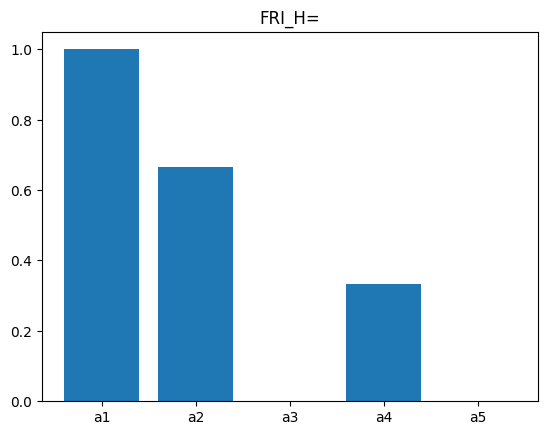

In [6]:
def compare_score_on_dataset(
    dimension, categorical_range, function, number_of_test, sample_size
):
    # real_correct_list = get_list_relevant_features(function, dimension) USElESS AT THIS STAGE
    # INIT MEANS
    # mean_fri_scores_1 = [0] * dimension
    # mean_fri_scores_2 = [0] * dimension
    mean_fri_scores_3 = [0] * dimension
    mean_fri_scores_4 = [0] * dimension

    mean_chi_scores = [0] * dimension
    mean_mi_scores = [0] * dimension
    mean_shap_scores = [0] * dimension
    mean_sobol_scores = [0] * dimension

    for u in range(number_of_test):  # TO BE CLARIFIED
        filename = create_categorical_dataset(
            function, dimension, sample_size, categorical_range
        )
        sample_set, X, y, _, _ = load_dataset(filename)
        # k=int(dimension/3)-1  # SENSITIVE TO THE NUMBER OF CLASSES
        max_distance = 2
        # fri_scores_1 = get_fri_scores(dimension, sample_set, max_distance)
        # fri_scores_2 = get_fri_scores(dimension, sample_set, max_distance + 1)
        fri_scores_3 = get_fri_scores(dimension, sample_set, max_distance + 2)
        fri_scores_4 = get_fri_scores(dimension, sample_set, max_distance + 3)

        chi_scores, _ = chi2(X, y)
        mi_scores = mutual_info_classif(
            X, y, discrete_features="auto", n_neighbors=3, copy=True, random_state=None
        )

        # CREATE MODEL FOR SHAPLEY AND SOBOL (convert to float)
        X = X.astype(float)
        y = y.astype(float)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.7, random_state=7
        )
        model = xgboost.XGBClassifier(eval_metric="logloss").fit(X_train, y_train)
        # SHAPLEY
        explainer = shap.Explainer(model, X_train)
        shap_values = explainer.shap_values(X_test)  # TO BE CHECKED ????
        shap_scores = np.abs(shap_values).mean(axis=0)

        # SOBOL ORDER 1 ONLY
        dataset = read_csv(filename, header=None)
        dataA = (dataset.values).astype(float)
        dataA = dataA[:, :-1]

        filenameB = create_categorical_dataset(
            function, dimension, sample_size, categorical_range
        )
        datasetB = read_csv(filenameB, header=None)
        dataB = (datasetB.values).astype(float)
        dataB = dataB[:, :-1]

        sobol_scores = []
        # total = []
        for i in range(dimension):
            results = sobol_indice_1st_and_total_order(model, i, dataA, dataB)
            sobol_scores.append(results[0])
            # total.append(results[1])

        # UPDATE MEAN SCORES BY ADDING NORMALIZED SCORES IN [0,1]
        for j in range(dimension):
            # mean_fri_scores_1[j] += fri_scores_1[j]  # /(Z_fri_1)
            # mean_fri_scores_2[j] += fri_scores_2[j]  # /(Z_fri_2)
            mean_fri_scores_3[j] += fri_scores_3[j]  # /(Z_fri_3)
            mean_fri_scores_4[j] += fri_scores_4[j]  # /(Z_fri_4)

            mean_chi_scores[j] += chi_scores[j]  # /(Z_chi)
            mean_mi_scores[j] += mi_scores[j]  # /(Z_mi)
            mean_shap_scores[j] += shap_scores[j]  # /(Z_mi)
            mean_sobol_scores[j] += sobol_scores[j]  # /(Z_mi)

    # mean_fri_scores_1 = [round(a * (1 / number_of_test), 2) for a in mean_fri_scores_1]
    # print("fri1", mean_fri_scores_1)
    # mean_fri_scores_2 = [round(a * (1 / number_of_test), 2) for a in mean_fri_scores_2]
    # print("fri2", mean_fri_scores_2)
    mean_fri_scores_3 = [round(a * (1 / number_of_test), 2) for a in mean_fri_scores_3]
    # print("fri3", mean_fri_scores_3)
    mean_fri_scores_4 = [round(a * (1 / number_of_test), 2) for a in mean_fri_scores_4]
    # print("fri4", mean_fri_scores_4)

    mean_chi_scores = [round(a * (1 / number_of_test), 2) for a in mean_chi_scores]
    mean_mi_scores = [round(a * (1 / number_of_test), 2) for a in mean_mi_scores]
    mean_shap_scores = [round(a * (1 / number_of_test), 2) for a in mean_shap_scores]
    mean_sobol_scores = [round(a * (1 / number_of_test), 2) for a in mean_sobol_scores]

    # PLOTTING RESULTS
    attribute_names = []
    for i in range(dimension):
        attribute_names.append("a" + str(i + 1))
    # plt.title("FRI_H=" + str(max_distance))
    # plt.bar(attribute_names, mean_fri_scores_1)
    # plt.show()
    # plt.title("FRI_H=" + str(max_distance + 1))
    # plt.bar(attribute_names, mean_fri_scores_2)
    # plt.show()

    plt.title("FRI_H=" + str(max_distance + 2))
    plt.bar(attribute_names, mean_fri_scores_3)
    plt.show()
    plt.title("FRI_H=" + str(max_distance + 3))
    plt.bar(attribute_names, mean_fri_scores_4)
    plt.show()

    plt.title("CHI-SQUARE")
    plt.bar(attribute_names, mean_chi_scores)
    plt.show()

    plt.title("MUTUAL INFORMATION")
    plt.bar(attribute_names, mean_mi_scores)
    plt.show()

    plt.title("SHAPLEY SCORES")
    plt.bar(attribute_names, mean_shap_scores)
    plt.show()

    plt.title("SOBOL SCORES")
    plt.bar(attribute_names, mean_sobol_scores)
    plt.show()
    # print(mean_fri_scores_4)
    return True

def compare_score_on_example(filename):
    data, X, y, dimension, initial_size =load_dataset(filename)
    max_distance=1
    scores= get_fri_scores(dimension, data, max_distance)
    # PLOTTING RESULTS
    attribute_names = []
    for i in range(dimension):
        attribute_names.append("a" + str(i + 1))
    print(dimension, initial_size,attribute_names)
    return attribute_names, scores


    
# MAIN LOOP
CATEGORICAL_RANGE = 1  # 1 means binary - range of values for feature
NUMBER_OF_TEST = 20

list_of_dimension = [] #[11]
list_sample_size = [500]
list_of_function = [g7]
for dimension in list_of_dimension:
    for sample_size in list_sample_size:
        for function in list_of_function:
            print(
                "dimension:",
                dimension,
                "CATEGORICAL_RANGE:",
                CATEGORICAL_RANGE,
                "-- sample size:",
                sample_size,
                "-- function:",
                function,
            )
            compare_score_on_dataset(
                dimension, CATEGORICAL_RANGE, function, NUMBER_OF_TEST, sample_size
            )

filename="example/sampleSize10-dim5WithNoise.csv"
attribute_names, scores=compare_score_on_example(filename)
for i in scores:
    print(round(i,2)) 
plt.title("FRI_H=")
plt.bar(attribute_names, scores)
plt.show()